In [2]:
# Import Library yang Diperlukan
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from skimage.feature import hog
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Pengaturan Path dan Membaca Dataset
dataset_path = '/content/drive/MyDrive/katarak/dataset'  # Ganti dengan path dataset Anda
categories = ['normal', 'cataract', 'glaucoma', 'diabetic_retinopathy']

# Membaca gambar dan menyimpan informasi dalam DataFrame
data = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for img in os.listdir(category_path):
        img_path = os.path.join(category_path, img)
        data.append((img_path, category))

df = pd.DataFrame(data, columns=['image_path', 'label'])

In [4]:
# Data Cleaning
def check_image_validity(img_path):
    try:
        img = Image.open(img_path)
        img.verify()  # Memeriksa apakah gambar valid
        return True
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return False

df['valid'] = df['image_path'].apply(check_image_validity)
df_cleaned = df[df['valid']]

In [5]:
# Data Manipulasi
summary_table = df_cleaned['label'].value_counts().reset_index()
summary_table.columns = ['label', 'count']
print(summary_table)
print("Total images:", len(df_cleaned))

                  label  count
0  diabetic_retinopathy   1098
1                normal   1074
2              cataract   1038
3              glaucoma   1007
Total images: 4217


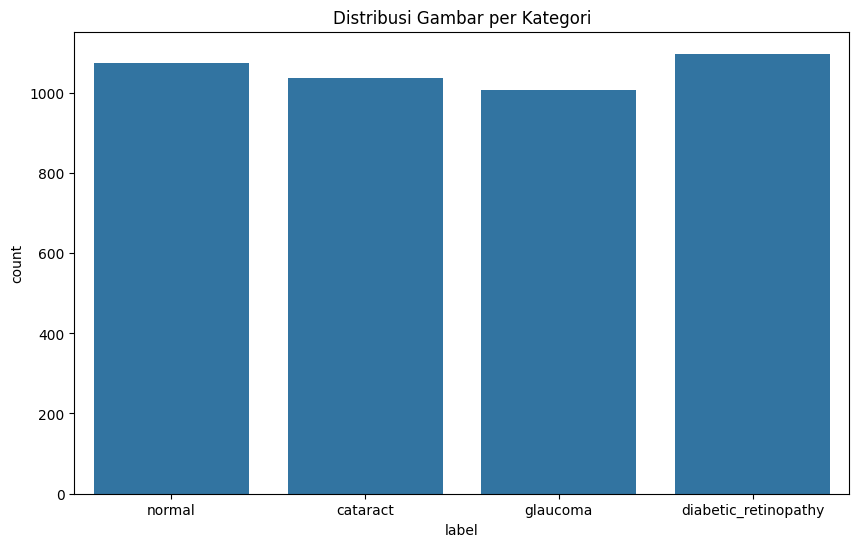

In [6]:
# Visualisasi Data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='label')
plt.title('Distribusi Gambar per Kategori')
plt.show()

In [7]:
# Data Augmentasi
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
# Ekstraksi Fitur
def extract_hog_features(img_path):
    img = Image.open(img_path).convert('L')  # Konversi ke grayscale
    img = img.resize((128, 128))  # Ubah ukuran gambar
    img_array = np.array(img)
    features, hog_image = hog(img_array, visualize=True)
    return features

df_cleaned['features'] = df_cleaned['image_path'].apply(extract_hog_features)

print("Mean and standard deviation of features:\n", df_cleaned['features'].apply(lambda x: np.mean(x)).describe())

Mean and standard deviation of features:
 count    4217.000000
mean        0.071911
std         0.009694
min         0.041995
25%         0.067450
50%         0.073701
75%         0.078632
max         0.094370
Name: features, dtype: float64


In [9]:
# Persiapan Data untuk Model
X = np.array(df_cleaned['features'].tolist())
y = df_cleaned['label'].values

# One-hot encoding
lb = LabelBinarizer()
y = lb.fit_transform(y)

# Membagi data menjadi data pelatihan dan pengujian
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Membangun Model untuk Fitur HOG
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))  # Input shape sesuai dengan jumlah fitur HOG
model.add(Dropout(0.5))  # Dropout untuk mengurangi overfitting
model.add(Dense(len(categories), activation='softmax'))  # Output layer dengan softmax untuk klasifikasi multi-kelas

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Menampilkan ringkasan model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │       2,032,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,032,772 (7.75 MB)

 Trainable params: 2,032,772 (7.75 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Melatih Model dengan Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_hog.keras', save_best_only=True)

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.5157 - loss: 1.1507 - val_accuracy: 0.7180 - val_loss: 0.6577
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7380 - loss: 0.6213 - val_accuracy: 0.7915 - val_loss: 0.5047
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7539 - loss: 0.5426 - val_accuracy: 0.8306 - val_loss: 0.4499
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7826 - loss: 0.4934 - val_accuracy: 0.8187 - val_loss: 0.4676
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8138 - loss: 0.4554 - val_accuracy: 0.8246 - val_loss: 0.4272
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8269 - loss: 0.4329 - val_accuracy: 0.8069 - val_loss: 0.4527
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8399 - loss: 0.3912 - val_accuracy: 0.8341 - val_loss: 0.4219
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8604 - loss: 0.3483 - val_accu

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       203
           1       0.99      1.00      0.99       203
           2       0.75      0.76      0.75       193
           3       0.82      0.84      0.83       245

    accuracy                           0.86       844
   macro avg       0.86      0.86      0.86       844
weighted avg       0.86      0.86      0.86       844



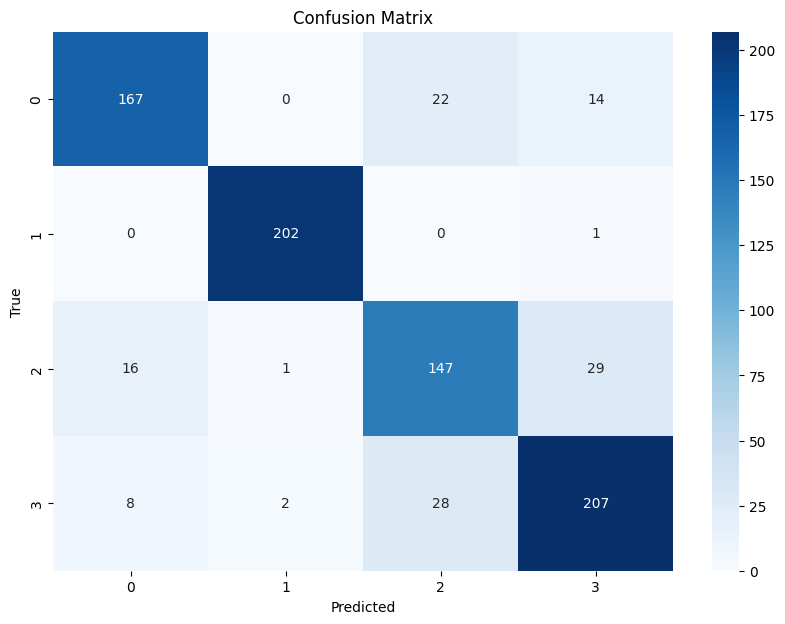

In [12]:
# Evaluasi Model
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

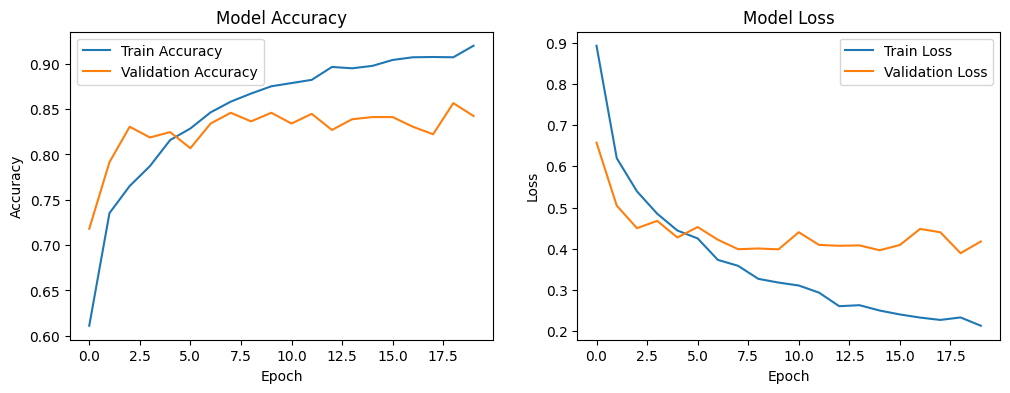

In [13]:
# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Pengujian Model dengan Gambar Baru
def predict_image(image_path):
    try:
        img = Image.open(image_path).resize((128, 128))
        img_array = np.array(img).reshape(1, 128, 128, 3) / 255.0
        prediction = model.predict(img_array)
        class_index = np.argmax(prediction)
        return lb.classes_[class_index]
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None

# Contoh penggunaan
test_image_path = 'path/to/test/image.jpg'  # Ganti dengan path gambar yang ingin diuji
predicted_class = predict_image(test_image_path)
print(f'Predicted class for the test image: {predicted_class}')

Classification Report:
                       precision    recall  f1-score   support

            cataract       0.87      0.82      0.85       203
diabetic_retinopathy       0.99      1.00      0.99       203
            glaucoma       0.75      0.76      0.75       193
              normal       0.82      0.84      0.83       245

            accuracy                           0.86       844
           macro avg       0.86      0.86      0.86       844
        weighted avg       0.86      0.86      0.86       844



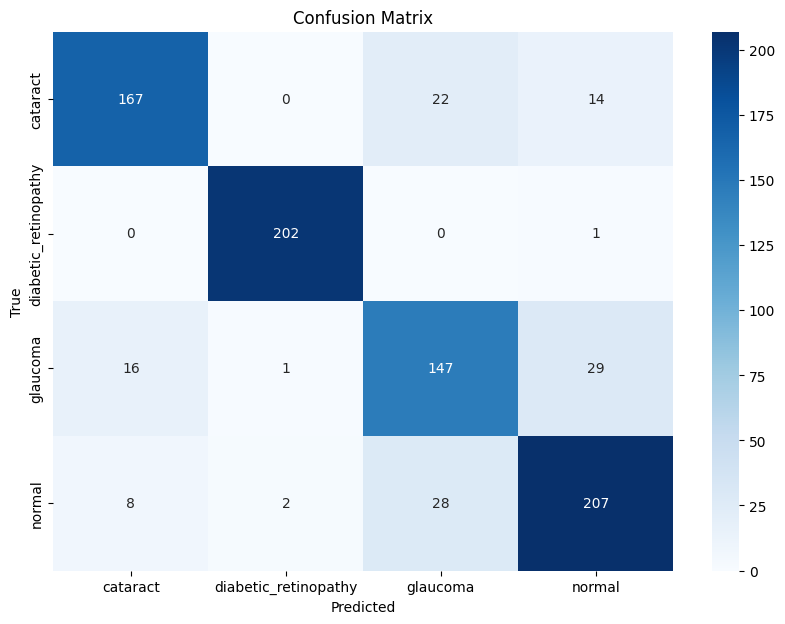

In [14]:
# Analisis Hasil
def analyze_results(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=lb.classes_)
    print("Classification Report:\n", report)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Analisis hasil
analyze_results(y_true_classes, y_pred_classes)

In [16]:
# Membuat model SVM
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

In [17]:
# Membuat model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Model ini juga siap untuk dilatih dengan data

In [19]:
# Mengubah y kembali ke bentuk satu dimensi
y_train_1d = np.argmax(y_train, axis=1)
y_val_1d = np.argmax(y_val, axis=1)

# Melatih model SVM
svm_model.fit(X_train, y_train_1d)

# Melatih model Random Forest
rf_model.fit(X_train, y_train_1d)

RandomForestClassifier(random_state=42)

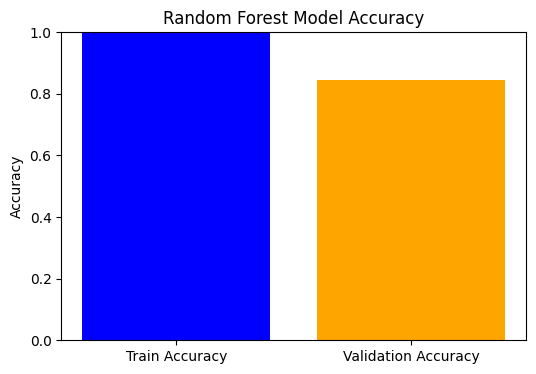

In [20]:
# Memprediksi pada data pelatihan dan validasi
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

# Menghitung akurasi
train_accuracy_rf = accuracy_score(y_train_1d, y_train_pred_rf)
val_accuracy_rf = accuracy_score(y_val_1d, y_val_pred_rf)

# Visualisasi akurasi
plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_accuracy_rf, val_accuracy_rf], color=['blue', 'orange'])
plt.title('Random Forest Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

Random Forest Classification Report:
                       precision    recall  f1-score   support

            cataract       0.85      0.79      0.82       203
diabetic_retinopathy       0.98      1.00      0.99       203
            glaucoma       0.76      0.66      0.71       193
              normal       0.80      0.91      0.85       245

            accuracy                           0.84       844
           macro avg       0.84      0.84      0.84       844
        weighted avg       0.84      0.84      0.84       844



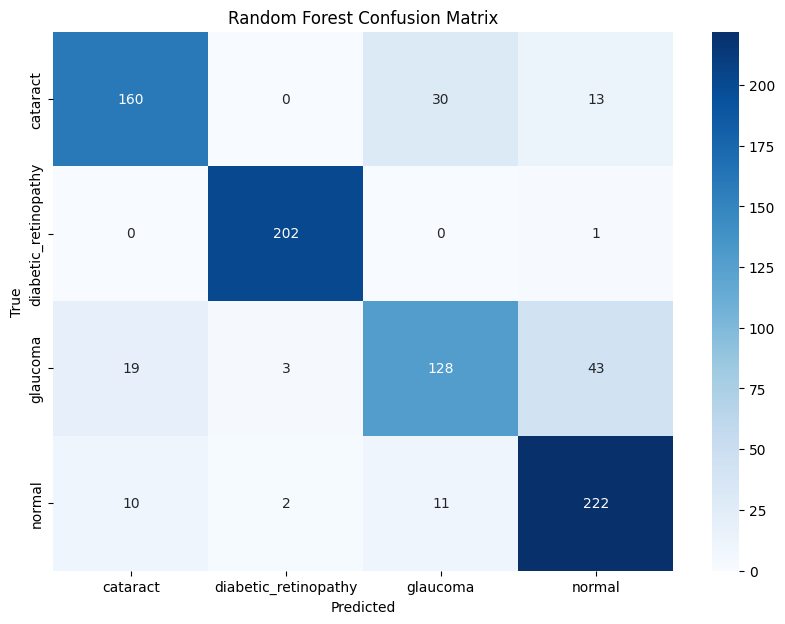

In [21]:
# Menghitung classification report
print("Random Forest Classification Report:\n", classification_report(y_val_1d, y_val_pred_rf, target_names=lb.classes_))

# Menghitung confusion matrix
cm_rf = confusion_matrix(y_val_1d, y_val_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

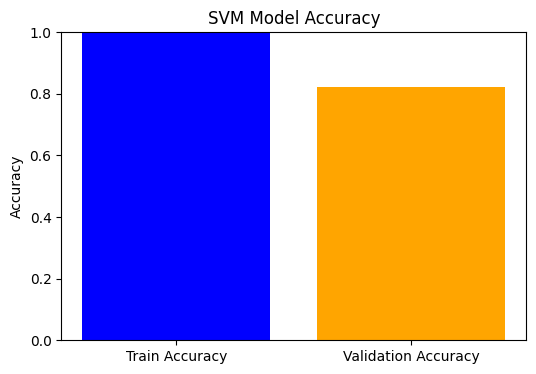

In [22]:
# Memprediksi pada data pelatihan dan validasi
y_train_pred_svm = svm_model.predict(X_train)
y_val_pred_svm = svm_model.predict(X_val)

# Menghitung akurasi
train_accuracy_svm = accuracy_score(y_train_1d, y_train_pred_svm)
val_accuracy_svm = accuracy_score(y_val_1d, y_val_pred_svm)

# Visualisasi akurasi
plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_accuracy_svm, val_accuracy_svm], color=['blue', 'orange'])
plt.title('SVM Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

SVM Classification Report:
                       precision    recall  f1-score   support

            cataract       0.78      0.84      0.81       203
diabetic_retinopathy       0.99      0.99      0.99       203
            glaucoma       0.68      0.70      0.69       193
              normal       0.83      0.76      0.79       245

            accuracy                           0.82       844
           macro avg       0.82      0.82      0.82       844
        weighted avg       0.82      0.82      0.82       844



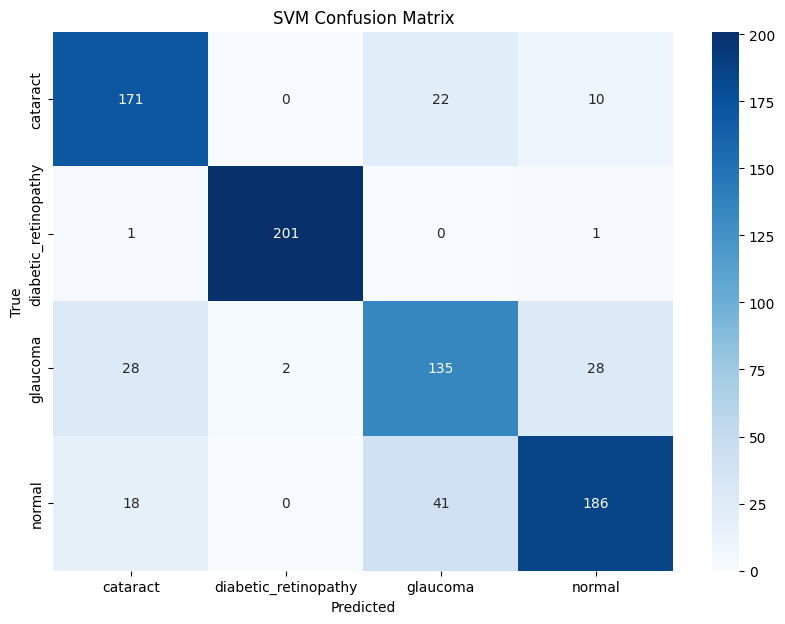

In [23]:
# Menghitung classification report
print("SVM Classification Report:\n", classification_report(y_val_1d, y_val_pred_svm, target_names=lb.classes_))

# Menghitung confusion matrix
cm_svm = confusion_matrix(y_val_1d, y_val_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVM Confusion Matrix')
plt.show()

1. Akurasi
- Neural Network: 86%
- Random Forest: 84%
- SVM: 82%

 Dari segi akurasi, Neural Network memiliki performa terbaik, diikuti oleh Random Forest, dan SVM di posisi terakhir.

2. Precision dan Recall
- Neural Network: Memiliki precision dan recall yang tinggi untuk semua kategori, terutama untuk "diabetic_retinopathy".
- Random Forest: Juga menunjukkan precision dan recall yang baik, tetapi ada beberapa kesulitan dalam mengklasifikasikan "glaucoma".
- SVM: Precision dan recall untuk "glaucoma" lebih rendah dibandingkan dengan model lainnya, menunjukkan bahwa model ini mungkin kesulitan dalam membedakan kategori tersebut.
3. Generalizability
- Neural Network: Dengan akurasi yang lebih tinggi dan metrik evaluasi yang baik, model ini tampaknya lebih mampu menggeneralisasi pada data yang tidak terlihat.
- Random Forest: Juga menunjukkan kemampuan generalisasi yang baik, tetapi sedikit lebih rendah dibandingkan Neural Network.
- SVM: Meskipun akurasinya masih baik, performa yang lebih rendah pada beberapa kategori menunjukkan bahwa model ini mungkin kurang efektif dalam generalisasi.
4. Kompleksitas Model
- Neural Network: Biasanya lebih kompleks dan memerlukan lebih banyak data untuk pelatihan yang efektif.
- Random Forest: Lebih mudah diinterpretasikan dan seringkali lebih cepat dalam pelatihan dibandingkan Neural Network.
- SVM: Dapat menjadi lambat pada dataset besar dan memerlukan pemilihan parameter yang hati-hati.

Kesimpulan

Neural Network adalah model yang paling efektif berdasarkan akurasi dan metrik evaluasi lainnya. Ini adalah pilihan yang baik jika Anda memiliki cukup data dan sumber daya untuk melatih model yang lebih kompleks.
Random Forest adalah pilihan yang baik jika Anda mencari keseimbangan antara akurasi dan interpretabilitas, serta lebih cepat dalam pelatihan.
SVM mungkin kurang efektif dalam konteks ini, terutama jika Anda menghadapi tantangan dalam membedakan beberapa kategori.